# Clustering for all dataset, NeMg

In [38]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
parent_dir1 = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(parent_dir1)

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch import nn
import torch.nn.functional as F
from simspice.data.SproutDataset_NeMg import SproutDataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import numpy as np
import matplotlib.pyplot as plt
from cuml.cluster.hdbscan import HDBSCAN
from cuml.cluster.hdbscan import all_points_membership_vectors


import matplotlib.pyplot as plt
from lightly.loss import NTXentLoss

import simspice.utils.inverse_mapping_functions as imf
# import simspice.models.Siamese_Architecture as SA
# import simspice.models.Siamese_Architecture_Transformer as SA
import simspice.models.Siamese_Architecture_Resnet as SA
# import simspice.models.SimCLR_Architecture_Resnet as SA
import wandb
#import umap.umap_ as umap
import tqdm
from datetime import datetime

plt.rcParams['image.origin'] = 'lower'

BATCH_SIZE = 128

In [3]:
simspice = "/d0/tvaresano/SimSPICE/"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [46]:
dataset_path = simspice+"spectra_train_NeMg.nc"
# dataset_path = simspice+"/spectra_Feb2023_NeMg.nc"
dataset_none = SproutDataset(dataset_path=dataset_path, augmentation_type=None, csv_files=simspice+'L2_names.csv',
                                           log_space=False, normalize_intensity=False)

In [5]:
id = 'resnet50_SimSiam_NeMg_gain01-3'

In [6]:
stacked_outputs = np.load(simspice+f'notebooks/jobs/model_outputs/stacked_outputs_single32_full_{id}_fullrun.npy')

In [41]:
x,y = 300,100
clusterer = HDBSCAN(min_cluster_size=x, min_samples=y, metric='euclidean', allow_single_cluster=True, prediction_data=True) # <=> cosine?

clusterer.fit(stacked_outputs)
labels = clusterer.labels_
np.save(simspice+f'notebooks/jobs/clustering/Fulltrained_single32_{id}_minclus{x}_minsamp{y}__all.npy', labels)

In [8]:
# x,y = 500,300
# x,y = 100,100
# x,y = 300,100  # ++ (~60 clusters)

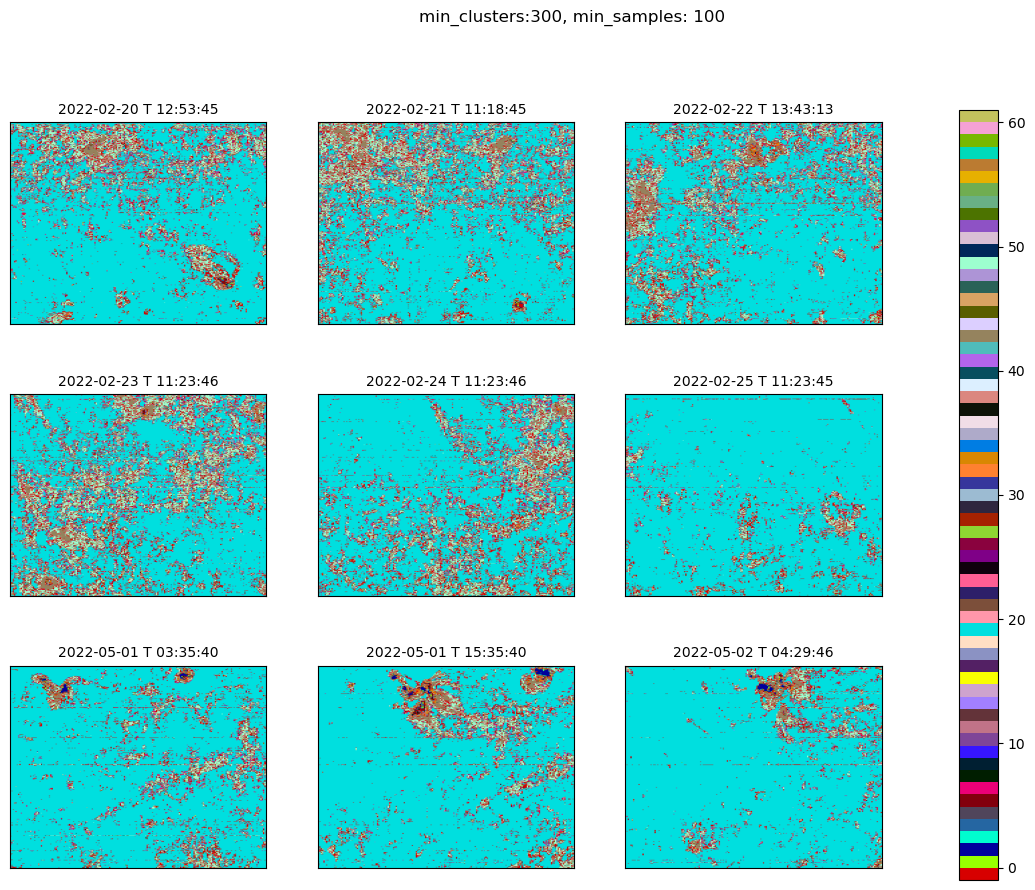

In [9]:
labels = np.load(simspice+f'notebooks/jobs/clustering/Fulltrained_single32_{id}_minclus{x}_minsamp{y}__all.npy')
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  

cmap = None
norm = None
for idx, ax in enumerate(axes.ravel()):
    img, cmap, norm = imf.map_clusters(
        labels,
        dataset_path=simspice+"spectra_train.nc",
        ax=ax,
        selected_clusters=None,
        file_index=idx,  # each subplot shows a different file
        cmap=cmap,
        norm=norm
    )

# Add ONE shared colorbar
fig.colorbar(img, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.2, pad=0.05, anchor=(.1,.2))
plt.suptitle(f'min_clusters:{x}, min_samples: {y}')
# plt.tight_layout()
plt.show()

In [10]:
from matplotlib.cm import get_cmap
all_clusters = np.unique(labels[~np.isnan(labels)])
cmap = get_cmap("cet_glasbey_bw", len(all_clusters))

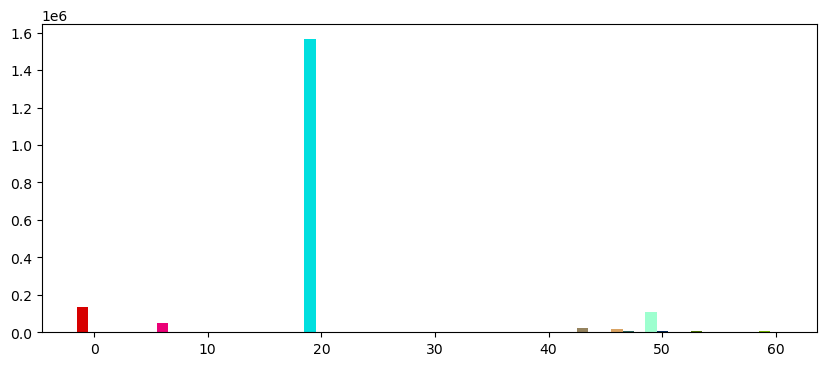

In [31]:
plt.figure(figsize=(10,4))
n, bins, patches = plt.hist(labels, bins=all_clusters, align='left')
for i, patch in enumerate(patches):
    patch.set_facecolor(cmap.colors[i])
# plt.yscale('log')


labels shape:  (1974720, 1)


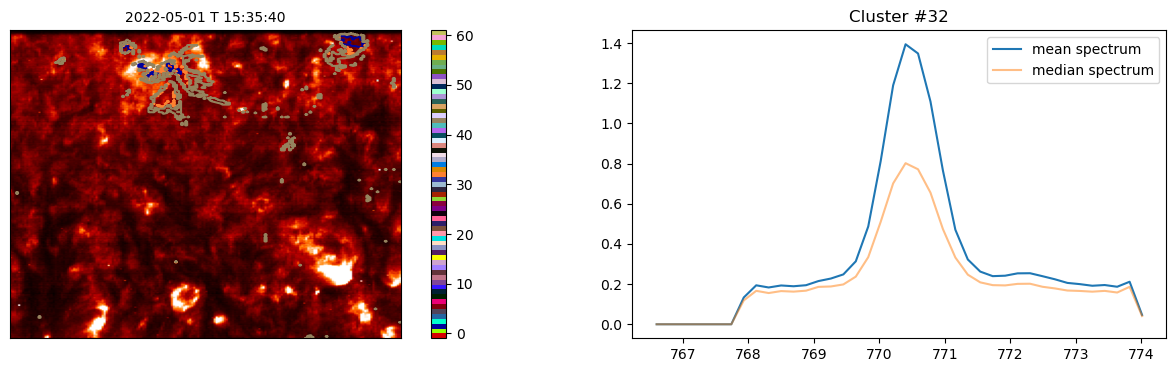

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16,4), gridspec_kw={'width_ratios': [1, .9]})
img, cmap, norm = imf.map_clusters(labels,
        dataset_path=simspice+"spectra_train.nc",
        ax=axes[0], selected_clusters=[1,43,32], data_dir='/d0/tvaresano/SimSPICE/data_L2/',
        file_index=7, cmap=cmap, norm=norm, contour=True, linewidth=1.5)
plt.title(f"min_cluster = {x}\nmin_samples = {y}")
plt.colorbar(img, ax=axes[0], orientation="vertical")


ax = axes[1]
imf.plot_average_spectra_cluster(labels, stacked_outputs, chosen_cluster=32, 
                                    dataset=dataset_none, log_scale=False,
                                    dataset_path=dataset_path, wvl=imf.WAVELENGTHS_ARRAY_NEMG);

In [42]:
soft_clusters = all_points_membership_vectors(clusterer)
soft_clusters[0]

array([7.6010591e-39, 7.4521164e-39, 7.5278903e-39, 7.6693219e-39,
       7.7131139e-39, 7.7757435e-39, 1.5844402e-38, 7.8302554e-39,
       7.8635082e-39, 1.1332175e-38, 1.0728775e-38, 1.0765663e-38,
       1.0904550e-38, 1.0995829e-38, 1.1036896e-38, 1.1230478e-38,
       1.1123087e-38, 1.0659362e-38, 1.0599095e-38, 1.0000000e+00,
       1.5925446e-38, 1.0509996e-38, 1.0540343e-38, 1.0376137e-38,
       1.0127376e-38, 1.0303816e-38, 1.0197577e-38, 9.9846719e-39,
       1.0270261e-38, 7.8814981e-39, 7.9274705e-39, 7.9568473e-39,
       7.9931900e-39, 8.1009429e-39, 8.1103918e-39, 8.1256562e-39,
       8.3944056e-39, 8.5028254e-39, 8.1774439e-39, 8.5448616e-39,
       8.1859232e-39, 8.3996745e-39, 8.3501890e-39, 8.3744777e-39,
       8.4765987e-39, 8.1627247e-39, 9.8809773e-39, 9.7152569e-39,
       9.6428154e-39, 9.4248840e-39, 9.6101679e-39, 9.6256130e-39,
       9.5173137e-39, 9.4764294e-39, 9.4945398e-39, 9.4345152e-39,
       9.5687385e-39, 9.5787929e-39, 9.6323967e-39, 9.5723118e

In [43]:
import pandas as pd

In [44]:
pd.Series(clusterer.labels_).value_counts()

 19    1566403
-1      133219
 49     106053
 6       52097
 43      21200
        ...   
 61        320
 29        320
 11        318
 39        309
 56        301
Name: count, Length: 63, dtype: int64

The most populated clusters are 19 (looks like QS), -1 (noise?) and 49 / 6 (AR?)

labels shape:  (1974720, 1)


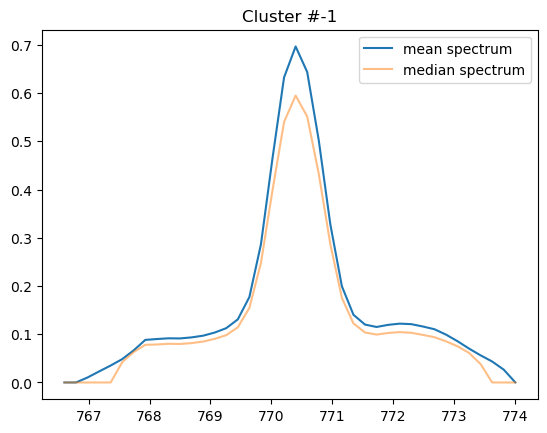

In [47]:
imf.plot_average_spectra_cluster(labels, stacked_outputs, chosen_cluster=-1, 
                                    dataset=dataset_none, log_scale=False,
                                    dataset_path=dataset_path, wvl=imf.WAVELENGTHS_ARRAY_NEMG);

labels shape:  (1974720, 1)
labels shape:  (1974720, 1)


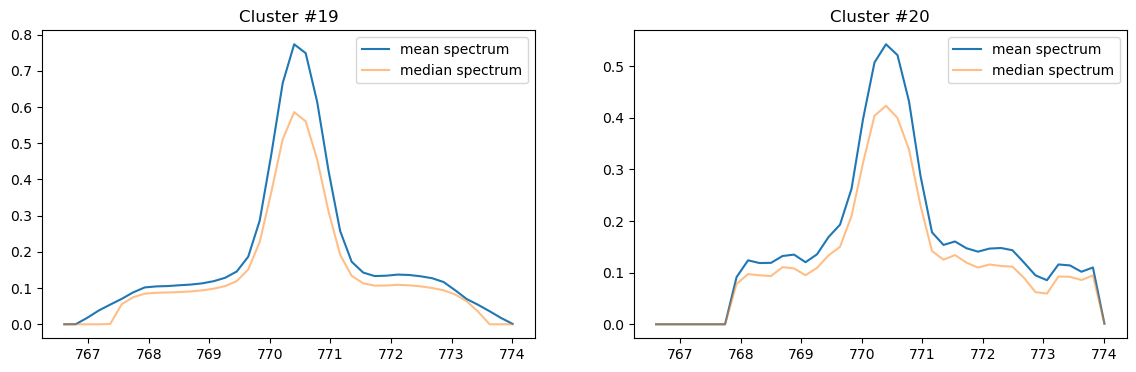

In [65]:
c=1
plt.figure(figsize=(14,4))
for clus in [19, 20]:
    plt.subplot(1,2,c)
    imf.plot_average_spectra_cluster(labels, stacked_outputs, chosen_cluster=clus, 
                                    dataset=dataset_none, log_scale=False,
                                    dataset_path=dataset_path, wvl=imf.WAVELENGTHS_ARRAY_NEMG);
    c+=1

labels shape:  (1974720, 1)
labels shape:  (1974720, 1)
labels shape:  (1974720, 1)
labels shape:  (1974720, 1)
labels shape:  (1974720, 1)


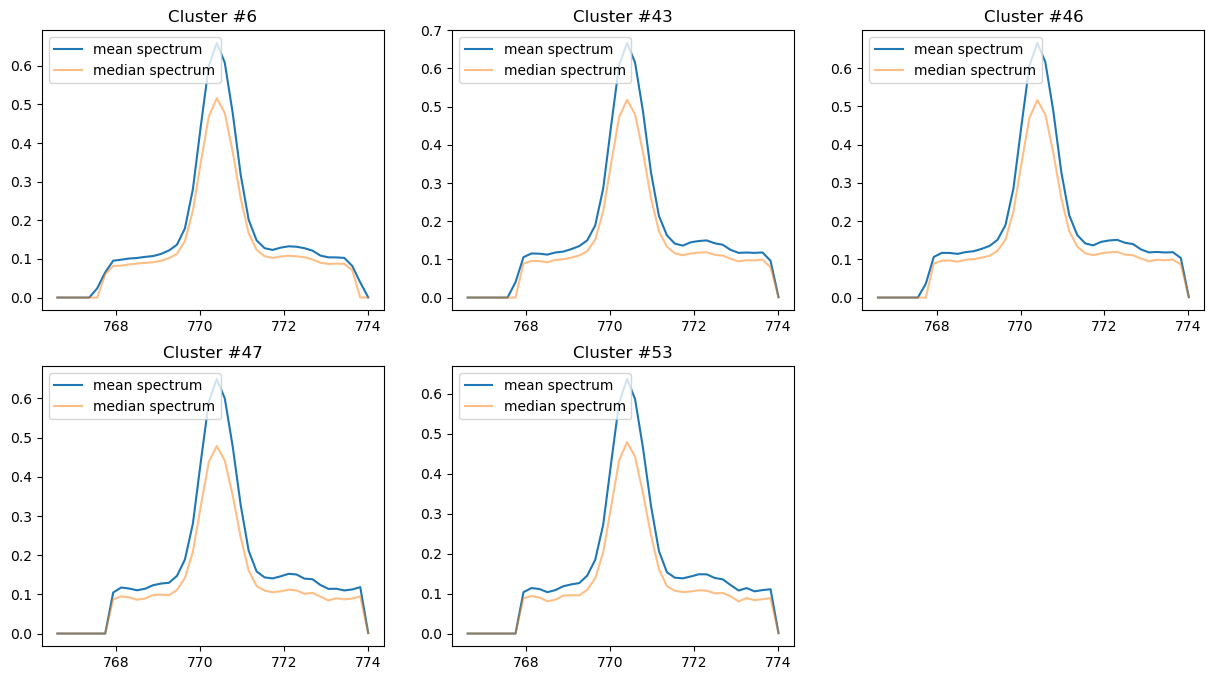

In [53]:
c=1
plt.figure(figsize=(15,8))
for clus in [6,43,46,47,53]:
    plt.subplot(2,3,c)
    imf.plot_average_spectra_cluster(labels, stacked_outputs, chosen_cluster=clus, 
                                    dataset=dataset_none, log_scale=False,
                                    dataset_path=dataset_path, wvl=imf.WAVELENGTHS_ARRAY_NEMG);
    c+=1

Building df2 : for every sample, its 3 most likely clusters.

In [63]:
df2 = pd.DataFrame(soft_clusters.argsort()[:,::-1][:,:3])
df2["sum"] = soft_clusters.sum(axis=1)
print(df2)

          0   1  2  sum
0        19  20  6  1.0
1        19  20  6  1.0
2        19  20  6  1.0
3        19  20  6  1.0
4        19  20  6  1.0
...      ..  .. ..  ...
1974715  19  20  6  1.0
1974716  19  20  6  1.0
1974717  19  20  6  1.0
1974718  19  20  6  1.0
1974719  19  20  6  1.0

[1974720 rows x 4 columns]


In [66]:
df3 = df2[df2[0] == -1].copy()
df3

,0,1,2,sum


# Predict for "unknown" dataset

In [50]:
dataset_path = simspice+"/spectra_Feb2023_NeMg.nc"
dataset_none = SproutDataset(dataset_path=dataset_path, augmentation_type=None, csv_files=simspice+'L2_names.csv',
                                           log_space=False, normalize_intensity=False)
checkpoint = '/d0/tvaresano/SimSPICE/notebooks/runs_single_augmentation_NeMg/resnet50_SimSiam_NeMg_gain01-3/checkpoints/epoch=8-step=138852.ckpt'
model = SA.SimSiam.load_from_checkpoint(
    checkpoint,
    output_dim=32,
    backbone_output_dim=64,
    hidden_layer_dim=64
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

loader = DataLoader(dataset_none, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

outputs = []
with torch.no_grad():
    for spec in tqdm.tqdm(loader):
        spec = spec.to(device)
        batch_out = model(spec)[0]  # shape: (batch, ...)
        outputs.append(batch_out.cpu())

feb_data = torch.cat(outputs, dim=0).numpy()

100%|██████████| 908/908 [00:11<00:00, 81.20it/s]


In [39]:
from cuml.cluster.hdbscan import approximate_predict

In [51]:
labels, strengths = approximate_predict(clusterer, feb_data)

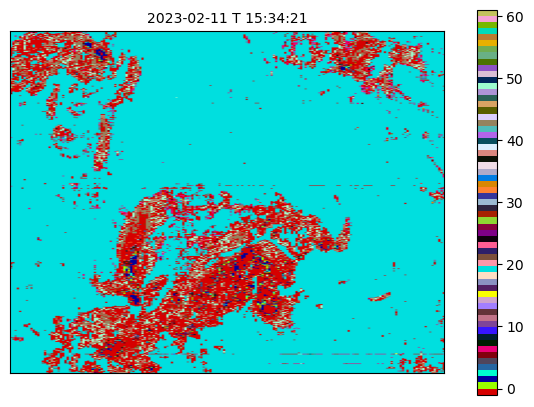

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))  
img, cmap, norm = imf.map_clusters(labels,
        dataset_path=simspice+"spectra_Feb2023.nc",
        ax=axes, selected_clusters=None,
        file_index=0, cmap=cmap, norm=norm )
fig.colorbar(img, ax=axes, orientation="vertical", fraction=0.15, pad=0.05, anchor=(.1,.2))
plt.show()